<a href="https://colab.research.google.com/github/SDashev/Springboard-Capstone-2/blob/work/Capstone_2_ml_model_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook uses Google colab to run

We will run model with transfer learning using exactly the same data used to train model from scratch. We will not shuffle or make any alterations to data we did not do using the model from scratch. 

This way, we will be able to truly compare the two types of models.

In [0]:
!pip install PyDrive

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar 23 19:24:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Fetching data

In [0]:
# in the colab files, I created work directory and moved the working directory.
os.chdir( 'work')

In [0]:
download = drive.CreateFile({'id': '1-0DzB-dUXarKs6GtULkZceszlyx9BcfT'})
download.GetContentFile('fruit-recognition.zip')

In [0]:
download = drive.CreateFile({'id': '1bE0dMhBKnbdA7fZCkE1CqUuL3cBVw-sL'})
download.GetContentFile('files_for_ml_cs2.zip')

In [7]:
!unzip -q fruit-recognition.zip  
!ls

Apple	   files_for_ml_cs2.zip   Kiwi	     Orange  Persimmon	Pomegranate
Banana	   fruit-recognition.zip  Mango      Peach   Pitaya	Tomatoes
Carambola  Guava		  muskmelon  Pear    Plum


In [8]:
!unzip -q files_for_ml_cs2.zip  
!ls

Apple			label_classes.csv  Plum
Banana			Mango		   Pomegranate
Carambola		muskmelon	   Tomatoes
filenames_shuffled.npy	Orange		   X_train_filenames.npy
files_for_ml_cs2.zip	Peach		   X_val_filenames.npy
fruit-recognition.zip	Pear		   y_labels_one_hot_shuffled.npy
Guava			Persimmon	   y_train.npy
Kiwi			Pitaya		   y_val.npy


In [9]:
!rm fruit-recognition.zip
!rm files_for_ml_cs2.zip
%reset_selective download

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Build model

In [0]:
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize

import keras

from keras import applications

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt

In [22]:
#Build CNN with transfer learning from VGG16 trained on imagenet
#from tensorflow.keras import models,layers
#from tensorflow.keras.applications import VGG16

cbase=applications.VGG16(weights='imagenet', include_top=False, input_shape=(258, 320, 3)) 
cbase.trainable=False # freeze convolutional base

transfer_m = Sequential()
transfer_m.add(cbase)
transfer_m.add(Flatten())

transfer_m.add(Dense(128, activation='relu', use_bias=
                     True, bias_initializer='zeros' ))
transfer_m.add(Dropout(0.25))

transfer_m.add(Dense(15, activation='softmax'))

transfer_m.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 10, 512)        14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               5243008   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                1935      
Total params: 19,959,631
Trainable params: 5,244,943
Non-trainable params: 14,714,688
_________________________________________________________________


## Custom data generator

In [0]:
class My_Custom_Generator(keras.utils.Sequence):

  

  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames = image_filenames

    self.labels = labels

    self.batch_size = batch_size

    
  def __len__(self) :

    return (np.ceil(len(self.image_filenames) / float(
        self.batch_size))).astype(np.int)

  

  def __getitem__(self, idx) :

    batch_x = self.image_filenames[idx * self.batch_size : (
        idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array([
            (imread(str(file_name))) for file_name in batch_x])/255.0, np.array(
                batch_y)

In [0]:
# loading variables
from keras.utils import to_categorical

# loading variables
X_train = np.load('X_train_filenames.npy')
y_train = to_categorical(np.load('y_train.npy'))

X_df = list(X_train)
y_df = list(y_train)

X_train_files = np.array(X_df[:44263])
y_train_values = np.array(y_df[:44263])
X_val_files = np.array(X_df[44263:])
y_val_values = np.array(y_df[44263:])

X_test_files = np.load('X_val_filenames.npy')
y_test = to_categorical(np.load('y_val.npy'))
name_classes = pd.read_csv('label_classes.csv')

In [0]:
batch_size = 95

my_training_batch_generator = My_Custom_Generator(
    X_train_files, y_train_values, batch_size)
my_validation_batch_generator = My_Custom_Generator(
    X_val_files, y_val_values, batch_size)

## Running model

In [0]:
transfer_m.compile(loss='categorical_crossentropy',optimizer=
                   'adam',metrics=['accuracy'])

load_weights = False #load weights if not re-fitting
if load_weights:
    transfer_m.load_weights('../model/vgg_baseline.hdf5')

In [24]:
#from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import Sequence
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=2)
if load_weights!=True:
  record = transfer_m.fit_generator(generator=my_training_batch_generator,
                 steps_per_epoch = int(44263 // batch_size),
                   epochs = 30,
                   #verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(4917 // batch_size),
                   callbacks=[early_stop_mon])

Epoch 1/30
465/465 [==============================] - 270s 581ms/step - loss: 0.8833 - acc: 0.7333 - val_loss: 0.1626 - val_acc: 0.9612
Epoch 2/30
465/465 [==============================] - 272s 585ms/step - loss: 0.3282 - acc: 0.8801 - val_loss: 0.1063 - val_acc: 0.9686
Epoch 3/30
465/465 [==============================] - 274s 589ms/step - loss: 0.2423 - acc: 0.9080 - val_loss: 0.0696 - val_acc: 0.9827
Epoch 4/30
465/465 [==============================] - 275s 591ms/step - loss: 0.2094 - acc: 0.9181 - val_loss: 0.0634 - val_acc: 0.9813
Epoch 5/30
465/465 [==============================] - 274s 590ms/step - loss: 0.1974 - acc: 0.9239 - val_loss: 0.0678 - val_acc: 0.9803
Epoch 6/30
465/465 [==============================] - 270s 581ms/step - loss: 0.1846 - acc: 0.9273 - val_loss: 0.0798 - val_acc: 0.9773


In [0]:
save_weights = True
if save_weights:
    transfer_m.save('../model/baseline_transfer.hdf5')
    #save history too
    hist_df=pd.DataFrame.from_dict(record.history)
    hist_df.to_csv('../model/history_transfer.csv')

In [0]:
#transfer_m.load_weights('../model/baseline_transfer.hdf5')

In [0]:
#hist=pd.read_csv('../model/history_transfer.csv')

## Evaluate model

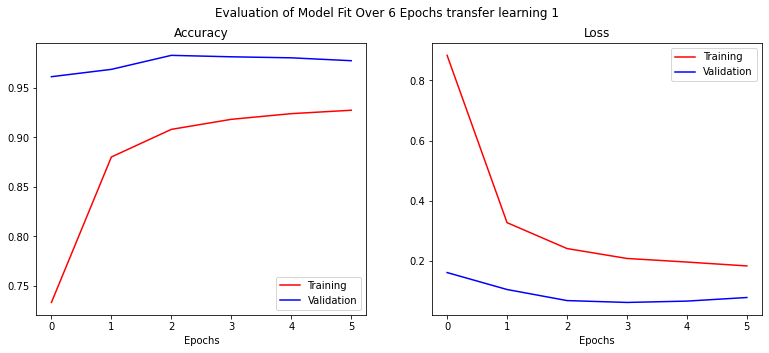

In [30]:
# Plot model fitting
# adapted from Deep Learning With Python (Chollet)
h = record.history
epochs = range(len(h['acc']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['acc'], 'r', label='Training')
ax[0].plot(epochs, h['val_acc'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over {} Epochs transfer learning 1'.format(len(h['acc'])));